In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Lambda, Conv1D, BatchNormalization

from tensorflow.keras import Model

In [2]:
# Load validation data
save_path = "data/validation_data/"
X_train = np.load(save_path + "X_train.npy")
Y_train = np.load(save_path + "Y_train.npy")#[:, 0]
X_test = np.load(save_path + "X_test.npy")
Y_test = np.load(save_path + "Y_test.npy")#[:, 0]
X_val = np.load(save_path + "X_val.npy")
Y_val = np.load(save_path + "Y_val.npy")#[:, 0]

# Only use win-loss target for training (wl models don't need odds)
Y_train = Y_train[:, 0]
Y_test = Y_test[:, 0]
Y_val = Y_val[:, 0]

In [3]:
# Loop through and train multiple models
epochs = 200
learning_rate = 5e-4
regularizer = "l1"

models = []
for i in range(7): # odd number for voting
    # Make the model
    input_layer = Input(shape=(X_train.shape[1]), name="wl_input")
    hidden_layer_1 = Dense(10, activation="relu", kernel_regularizer=regularizer, name="wl_hl_1")(input_layer)
    hidden_layer_2 = Dense(5, activation="relu", kernel_regularizer=regularizer, name="wl_hl_2")(hidden_layer_1)
    output_layer = Dense(1, activation="sigmoid", name="wl_output")(hidden_layer_2)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile and train the model
    loss = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1)]
    history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), 
                        batch_size=16, epochs=epochs, callbacks=callbacks, verbose=1)
    
    # Print final model accuracy
    val_acc = model.evaluate(X_val, Y_val, return_dict=True, verbose=0)['accuracy']
    print(f"Validation Accuracy: {val_acc*100:.2f}%")
    if val_acc < 0.55:
        print("Skipped.")
        continue
    models.append(model)

Epoch 1/200
700/700 [==============================] - 3s 3ms/step - loss: 1.2782 - accuracy: 0.5301 - val_loss: 0.9421 - val_accuracy: 0.5688
Epoch 2/200
700/700 [==============================] - 2s 3ms/step - loss: 0.7985 - accuracy: 0.5655 - val_loss: 0.7195 - val_accuracy: 0.5600
Epoch 3/200
700/700 [==============================] - 2s 2ms/step - loss: 0.7051 - accuracy: 0.5555 - val_loss: 0.6997 - val_accuracy: 0.5379
Epoch 4/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6953 - accuracy: 0.5495 - val_loss: 0.6952 - val_accuracy: 0.5383
Epoch 5/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6913 - accuracy: 0.5495 - val_loss: 0.6915 - val_accuracy: 0.5383
Epoch 6/200
700/700 [==============================] - 2s 3ms/step - loss: 0.6886 - accuracy: 0.5495 - val_loss: 0.6908 - val_accuracy: 0.5383
Epoch 7/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6886 - accuracy: 0.5495 - val_loss: 0.6908 - val_accuracy: 0.5383

Epoch 8/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6894 - accuracy: 0.5495 - val_loss: 0.6906 - val_accuracy: 0.5383
Epoch 9/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6889 - accuracy: 0.5567 - val_loss: 0.6906 - val_accuracy: 0.5383
Epoch 10/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6886 - accuracy: 0.5604 - val_loss: 0.6903 - val_accuracy: 0.5692
Epoch 11/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6884 - accuracy: 0.5713 - val_loss: 0.6898 - val_accuracy: 0.5675
Epoch 12/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6881 - accuracy: 0.5718 - val_loss: 0.6894 - val_accuracy: 0.5783
Epoch 13/200
700/700 [==============================] - 2s 2ms/step - loss: 0.6879 - accuracy: 0.5737 - val_loss: 0.6893 - val_accuracy: 0.5742
Epoch 14/200
700/700 [==============================] - 2s 3ms/step - loss: 0.6876 - accuracy: 0.5736 - val_loss: 0.6892 - val_accuracy: 0

700/700 [==============================] - 2s 3ms/step - loss: 1.3975 - accuracy: 0.5497 - val_loss: 1.1189 - val_accuracy: 0.5625
Epoch 2/200
700/700 [==============================] - 2s 2ms/step - loss: 0.9479 - accuracy: 0.5596 - val_loss: 0.8260 - val_accuracy: 0.5596
Epoch 3/200
700/700 [==============================] - 2s 2ms/step - loss: 0.7724 - accuracy: 0.5562 - val_loss: 0.7389 - val_accuracy: 0.5383
Epoch 4/200
 49/700 [=>............................] - ETA: 1s - loss: 0.7343 - accuracy: 0.5663

KeyboardInterrupt: 

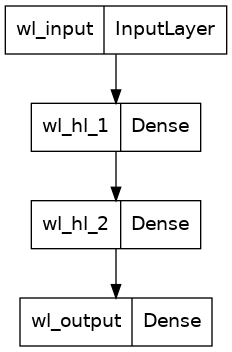

In [4]:
# Show the model architecture
tf.keras.utils.plot_model(models[0], to_file='model_images/wl_model.png')

In [ ]:
# Group predict
all_preds = np.array([m.predict(X_val, verbose=0).reshape(-1) for m in models])

mean_preds = all_preds.mean(axis=0) > 0.5
mean_acc = np.mean(mean_preds == Y_val)

vote_preds = (all_preds > 0.5).sum(axis=0) > (all_preds.shape[0]/2)
vote_acc = np.mean(vote_preds == Y_val)

print(f"Mean Accuracy: {mean_acc*100:.2f}%")
print(f"Vote Accuracy: {vote_acc*100:.2f}%")

In [ ]:
# Group testing
all_preds = np.array([m.predict(X_test, verbose=0).reshape(-1) for m in models])

mean_preds = all_preds.mean(axis=0) > 0.5
mean_acc = np.mean(mean_preds == Y_test)

vote_preds = (all_preds > 0.5).sum(axis=0) > (all_preds.shape[0]/2)
vote_acc = np.mean(vote_preds == Y_test)

print(f"Mean Accuracy: {mean_acc*100:.2f}%")
print(f"Vote Accuracy: {vote_acc*100:.2f}%")

In [ ]:
for i, model in enumerate(models):
    model.save(f"saved_models/win_loss_model/model_{i}")